# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig0900s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 400

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1177, 32, 20, 3)
(1177, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/400
295/295 [==============================] - 7s 12ms/step - loss: 2.1204 - accuracy: 0.3429
Epoch 2/400
295/295 [==============================] - 4s 14ms/step - loss: 1.2006 - accuracy: 0.6085
Epoch 3/400
295/295 [==============================] - 4s 15ms/step - loss: 0.8997 - accuracy: 0.7230
Epoch 4/400
295/295 [==============================] - 4s 14ms/step - loss: 0.7369 - accuracy: 0.7718
Epoch 5/400
295/295 [==============================] - 4s 12ms/step - loss: 0.6359 - accuracy: 0.8112
Epoch 6/400
295/295 [==============================] - 4s 13ms/step - loss: 0.5056 - accuracy: 0.8390
Epoch 7/400
295/295 [==============================] - 4s 13ms/step - loss: 0.4598 - accuracy: 0.8622
Epoch 8/400
295/295 [==============================] - 4s 13ms/step - loss: 0.3805 - accuracy: 0.8681
Epoch 9/400
295/295 [==============================] - 4s 12ms/step - loss: 0.4052 - accuracy: 0.8934
Epoch 10/400
295/295 [==============================] - 3s 12ms/step - loss: 0.370

295/295 [==============================] - 4s 13ms/step - loss: 0.0656 - accuracy: 0.9839
Epoch 80/400
295/295 [==============================] - 4s 12ms/step - loss: 0.0607 - accuracy: 0.9857
Epoch 81/400
295/295 [==============================] - 3s 11ms/step - loss: 0.0664 - accuracy: 0.9855
Epoch 82/400
295/295 [==============================] - 3s 12ms/step - loss: 0.0479 - accuracy: 0.9886 0s - los
Epoch 83/400
295/295 [==============================] - 4s 13ms/step - loss: 0.0823 - accuracy: 0.9743
Epoch 84/400
295/295 [==============================] - 3s 11ms/step - loss: 0.0588 - accuracy: 0.9848
Epoch 85/400
295/295 [==============================] - 3s 11ms/step - loss: 0.0474 - accuracy: 0.9823
Epoch 86/400
295/295 [==============================] - 3s 12ms/step - loss: 0.0815 - accuracy: 0.9753
Epoch 87/400
295/295 [==============================] - 4s 13ms/step - loss: 0.0785 - accuracy: 0.9709
Epoch 88/400
295/295 [==============================] - 4s 12ms/step - loss: 

295/295 [==============================] - 3s 11ms/step - loss: 0.0407 - accuracy: 0.9874
Epoch 157/400
295/295 [==============================] - 3s 11ms/step - loss: 0.0447 - accuracy: 0.9878
Epoch 158/400
295/295 [==============================] - 3s 11ms/step - loss: 0.0319 - accuracy: 0.9941
Epoch 159/400
295/295 [==============================] - 3s 12ms/step - loss: 0.0397 - accuracy: 0.9896
Epoch 160/400
295/295 [==============================] - 3s 12ms/step - loss: 0.0436 - accuracy: 0.9884
Epoch 161/400
295/295 [==============================] - 3s 11ms/step - loss: 0.0282 - accuracy: 0.9870
Epoch 162/400
295/295 [==============================] - 3s 12ms/step - loss: 0.0458 - accuracy: 0.9871
Epoch 163/400
295/295 [==============================] - 3s 12ms/step - loss: 0.0419 - accuracy: 0.9873
Epoch 164/400
295/295 [==============================] - 4s 12ms/step - loss: 0.0647 - accuracy: 0.9827 1s - ETA: 0s - loss: 0.0652 
Epoch 165/400
295/295 [==========================

295/295 [==============================] - 3s 9ms/step - loss: 0.0391 - accuracy: 0.9918: 0s - loss: 0.0357 - ac
Epoch 234/400
295/295 [==============================] - 3s 9ms/step - loss: 0.0481 - accuracy: 0.9889
Epoch 235/400
295/295 [==============================] - 4s 12ms/step - loss: 0.0505 - accuracy: 0.9895
Epoch 236/400
295/295 [==============================] - 3s 9ms/step - loss: 0.0358 - accuracy: 0.9838
Epoch 237/400
295/295 [==============================] - 3s 9ms/step - loss: 0.0346 - accuracy: 0.9882
Epoch 238/400
295/295 [==============================] - 3s 9ms/step - loss: 0.0428 - accuracy: 0.9899: 0s - loss:
Epoch 239/400
295/295 [==============================] - 3s 9ms/step - loss: 0.0662 - accuracy: 0.9882
Epoch 240/400
295/295 [==============================] - 3s 9ms/step - loss: 0.0227 - accuracy: 0.9943
Epoch 241/400
295/295 [==============================] - 3s 9ms/step - loss: 0.0224 - accuracy: 0.9908
Epoch 242/400
295/295 [===========================

295/295 [==============================] - 2s 8ms/step - loss: 0.0107 - accuracy: 0.9980
Epoch 311/400
295/295 [==============================] - 2s 8ms/step - loss: 0.0154 - accuracy: 0.9951
Epoch 312/400
295/295 [==============================] - 2s 8ms/step - loss: 0.0163 - accuracy: 0.9947
Epoch 313/400
295/295 [==============================] - 2s 8ms/step - loss: 0.0067 - accuracy: 0.9962
Epoch 314/400
295/295 [==============================] - 2s 8ms/step - loss: 0.0420 - accuracy: 0.9928
Epoch 315/400
295/295 [==============================] - 2s 8ms/step - loss: 0.0179 - accuracy: 0.9961
Epoch 316/400
295/295 [==============================] - 2s 8ms/step - loss: 0.0073 - accuracy: 0.9958
Epoch 317/400
295/295 [==============================] - 2s 8ms/step - loss: 0.0240 - accuracy: 0.9938
Epoch 318/400
295/295 [==============================] - 2s 8ms/step - loss: 0.0371 - accuracy: 0.9908
Epoch 319/400
295/295 [==============================] - 2s 8ms/step - loss: 0.0576 - a

295/295 [==============================] - 2s 7ms/step - loss: 0.0203 - accuracy: 0.9942
Epoch 389/400
295/295 [==============================] - 2s 7ms/step - loss: 0.0198 - accuracy: 0.9946
Epoch 390/400
295/295 [==============================] - 2s 7ms/step - loss: 0.0192 - accuracy: 0.9917
Epoch 391/400
295/295 [==============================] - 2s 7ms/step - loss: 0.0130 - accuracy: 0.9958
Epoch 392/400
295/295 [==============================] - 2s 7ms/step - loss: 0.0176 - accuracy: 0.9945
Epoch 393/400
295/295 [==============================] - 2s 7ms/step - loss: 0.0096 - accuracy: 0.9960
Epoch 394/400
295/295 [==============================] - 2s 6ms/step - loss: 0.0322 - accuracy: 0.9972
Epoch 395/400
295/295 [==============================] - 2s 6ms/step - loss: 0.0160 - accuracy: 0.9944
Epoch 396/400
295/295 [==============================] - 2s 6ms/step - loss: 0.0034 - accuracy: 0.9996
Epoch 397/400
295/295 [==============================] - 2s 7ms/step - loss: 0.0232 - a

### Learing result
 
* Visualization of the training and validation results

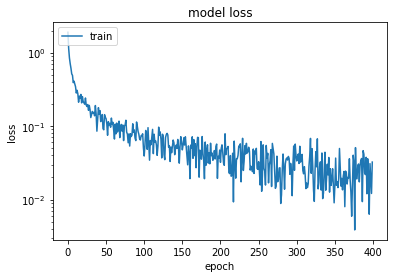

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

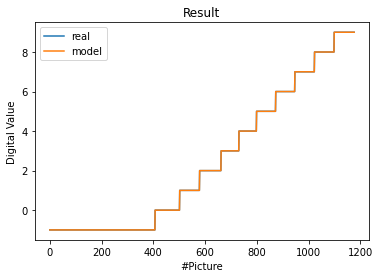

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp31t9zmt9\assets


766432

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp18qq8dmi\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp18qq8dmi\assets


203200

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.